In [84]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import h5py
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut

from importlib import reload
reload(ut)
import scipy.ndimage.filters as sfi
import scipy.stats as sst
import scipy.ndimage.measurements as snm
from mpl_toolkits.mplot3d import Axes3D
import size_contrast_analysis as sca
reload(sca)
import retinotopy_analysis as rt
reload(rt)
import naka_rushton_analysis as nra
import pdb
import sklearn
import pickle as pkl

In [90]:
data_struct = sio.loadmat('pyr_l23_data_struct.mat',squeeze_me=True)

In [91]:
keylist = [x for x in list(data_struct.keys()) if 'session_' in x]

In [92]:
def make_bullseye(nr,fr,bins_per_step=10):
    x = np.arange(-nr,nr,1/bins_per_step)
    xx,yy = np.meshgrid(x,x)
    rr = np.ceil(np.sqrt(xx**2+yy**2))
    F = np.zeros_like(xx)
    for ifr in range(nr):
        F[rr==ifr+1] = fr[ifr]
    return F

In [93]:
# plt.figure()
# plt.plot(data_struct[keylist[0]]['calcium_responses_au'].mean(0))
trialavg = {}
for key in keylist:
    session_id = key

    running = data_struct[session_id]['running_speed_cm_s'][()]>10
    nsize = len(data_struct[session_id]['stimulus_size_deg'][()])
    ncontrast = len(data_struct[session_id]['stimulus_contrast'][()])
    nroi = data_struct[session_id]['decon'][()].shape[0]
    snorm = np.zeros((nroi,nsize,ncontrast))
    for i in range(nsize):
        for j in range(ncontrast):
            size_id = data_struct[session_id]['stimulus_id'][()][0]
            contrast_id = data_struct[session_id]['stimulus_id'][()][1]
            gd_trial = np.logical_and(running,np.logical_and(size_id==i,contrast_id==j))
            snorm[:,i,j] = np.nanmean(data_struct[session_id]['decon'][()][:,gd_trial],axis=1)
    snorm = snorm - snorm[:,:,0].mean(1)[:,np.newaxis,np.newaxis]
    pos = snorm.max(-1).max(-1)>0
#     snorm = snorm/snorm.max(-1).max(-1)[:,np.newaxis,np.newaxis]

    re = np.arange(0,30,5)
    sig_ret = data_struct[session_id]['rf_mapping_pval'][()]<0.05
    R = np.digitize(data_struct[session_id]['rf_distance_deg'][()],re)

    trialavg[key] = np.zeros((R.max(),nsize,ncontrast))
    for r in range(R.max()):
        gd_roi = np.logical_and(pos,np.logical_and(R==r+1,sig_ret))
        trialavg[key][r] = np.nanmean(snorm[gd_roi],axis=0)

# trialavg = np.zeros((R.max(),nsize,ncontrast))
# for r in range(R.max()):
#     gd_roi = np.logical_and(R==r+1,sig_ret)
#     for i in range(nsize):
#         for j in range(ncontrast):
#             size_id = data_struct[session_id]['stimulus_id'][()][0]
#             contrast_id = data_struct[session_id]['stimulus_id'][()][1]
#             gd_trial = np.logical_and(running,np.logical_and(size_id==i,contrast_id==j))
#             trialavg[r,i,j] = np.nanmean(data_struct[session_id]['decon'][()][gd_roi][:,gd_trial])

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


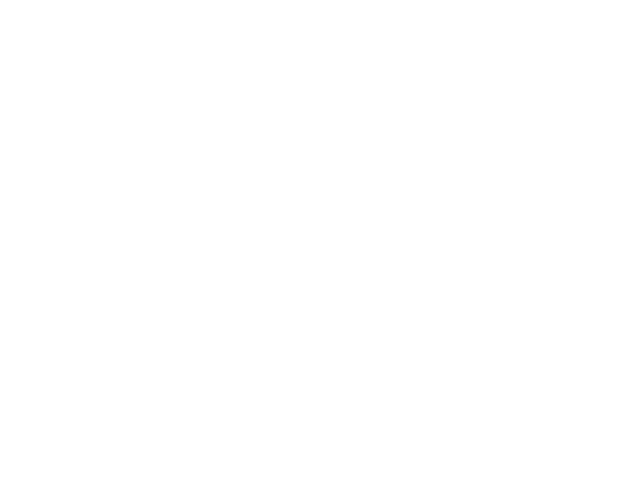

<IPython.core.display.Javascript object>


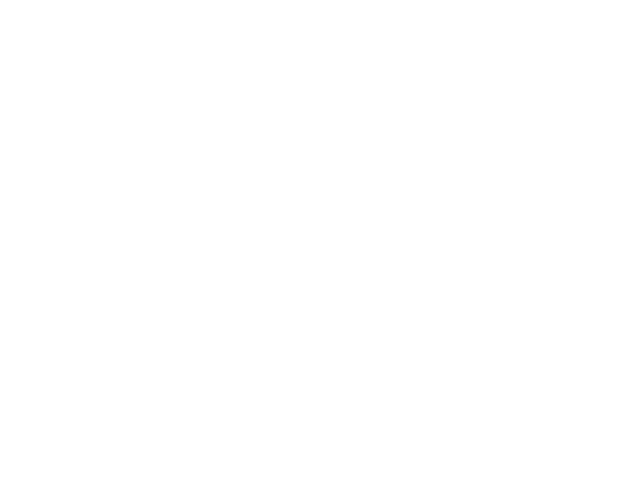

<IPython.core.display.Javascript object>


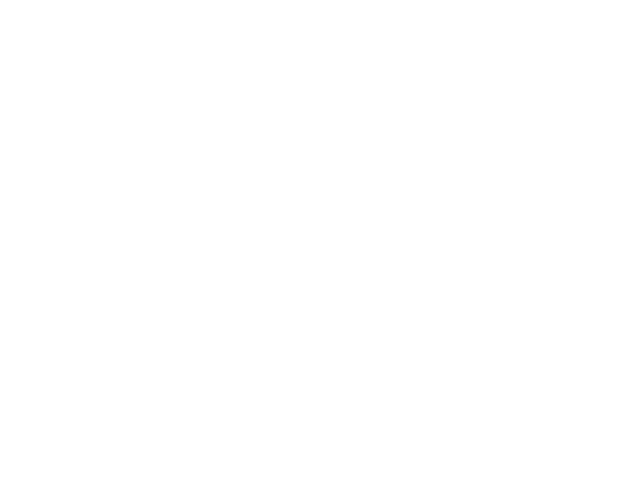

<IPython.core.display.Javascript object>


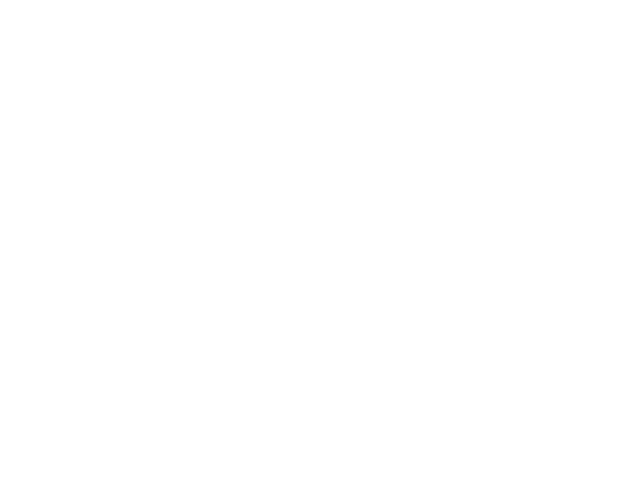

<IPython.core.display.Javascript object>


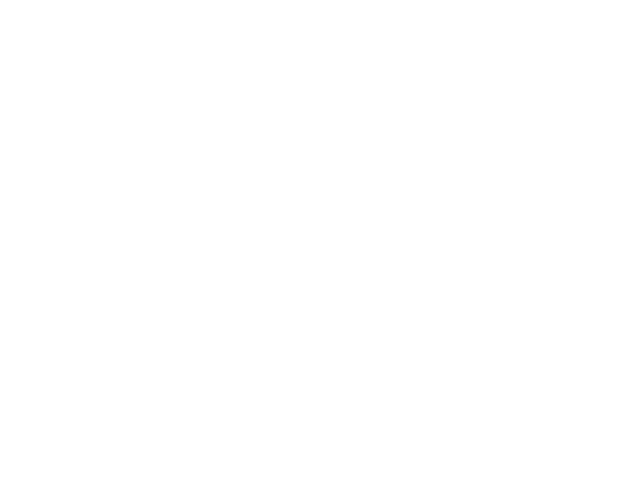

<IPython.core.display.Javascript object>


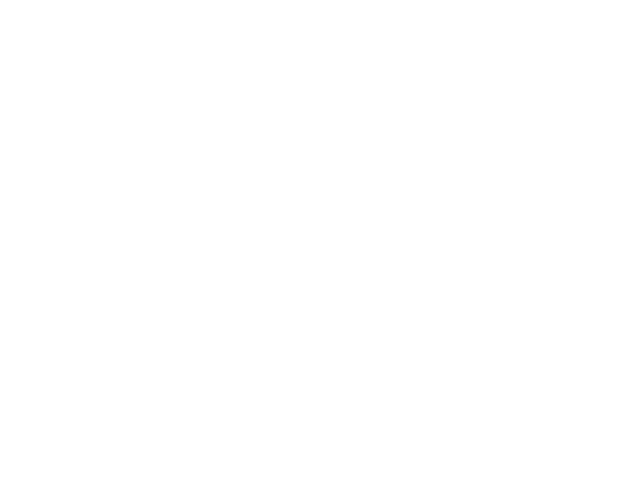

<IPython.core.display.Javascript object>


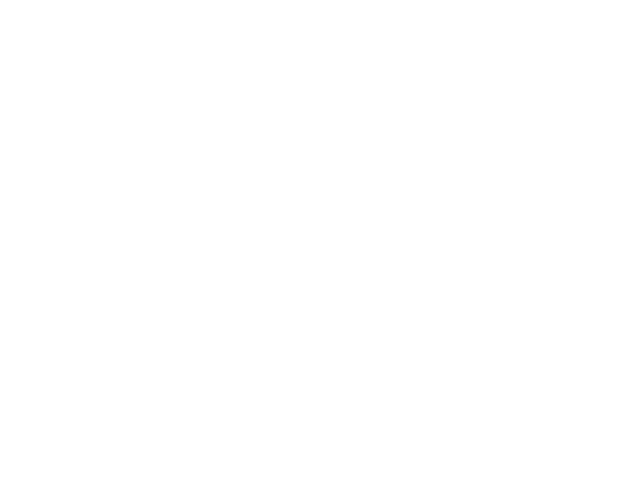

<IPython.core.display.Javascript object>


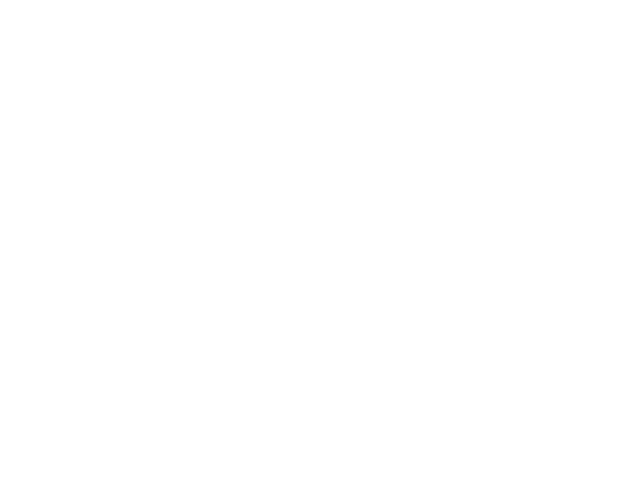

In [94]:
for key in keylist:
    plt.figure()
    for i in range(trialavg[key].shape[1]):
        for j in range(trialavg[key].shape[2]):
            plt.subplot(trialavg[key].shape[1],trialavg[key].shape[2],i*trialavg[key].shape[2]+j+1)
            plt.plot(trialavg[key][:,i,j])
            plt.imshow(make_bullseye(trialavg[key].shape[0],trialavg[key][:,i,j]),vmin=0,vmax=trialavg[key].max())
            plt.axis('off')

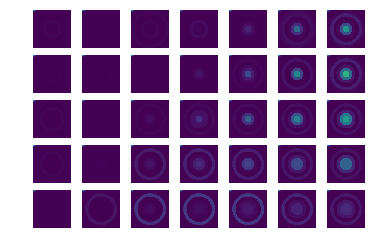

In [81]:
for key in (keylist[1],):
    plt.figure()
    for i in range(trialavg[key].shape[1]):
        for j in range(trialavg[key].shape[2]):
            plt.subplot(trialavg[key].shape[1],trialavg[key].shape[2],i*trialavg[key].shape[2]+j+1)
            plt.plot(trialavg[key][:,i,j])
            plt.imshow(make_bullseye(trialavg[key].shape[0],trialavg[key][:,i,j]),vmin=0,vmax=1)
            plt.axis('off')
    plt.savefig('size_contrast_by_rf.pdf')
    plt.savefig('size_contrast_by_rf.png')

In [65]:
# plt.figure()
# plt.plot(data_struct[keylist[0]]['calcium_responses_au'].mean(0))
trialavg = {}
for key in keylist:
    session_id = key

    running = data_struct[session_id]['running_speed_cm_s'][()]>10
    nsize = len(data_struct[session_id]['stimulus_size_deg'][()])
    ncontrast = len(data_struct[session_id]['stimulus_contrast'][()])
    nroi = data_struct[session_id]['decon'][()].shape[0]
    snorm = np.zeros((nroi,nsize,ncontrast))
    for i in range(nsize):
        for j in range(ncontrast):
            size_id = data_struct[session_id]['stimulus_id'][()][0]
            contrast_id = data_struct[session_id]['stimulus_id'][()][1]
            gd_trial = np.logical_and(running,np.logical_and(size_id==i,contrast_id==j))
            snorm[:,i,j] = np.nanmean(data_struct[session_id]['decon'][()][:,gd_trial],axis=1)
    snorm = snorm #/snorm.max(-1).max(-1)[:,np.newaxis,np.newaxis]

    re = np.arange(0,30,5)
    sig_ret = data_struct[session_id]['rf_mapping_pval'][()]<0.05
    R = np.digitize(data_struct[session_id]['rf_distance_deg'][()],re)

    trialavg[key] = np.zeros((R.max(),nsize,ncontrast))
    for r in range(R.max()):
        gd_roi = np.logical_and(R==r+1,sig_ret)
        trialavg[key][r] = np.nanmean(snorm[gd_roi],axis=0)

# trialavg = np.zeros((R.max(),nsize,ncontrast))
# for r in range(R.max()):
#     gd_roi = np.logical_and(R==r+1,sig_ret)
#     for i in range(nsize):
#         for j in range(ncontrast):
#             size_id = data_struct[session_id]['stimulus_id'][()][0]
#             contrast_id = data_struct[session_id]['stimulus_id'][()][1]
#             gd_trial = np.logical_and(running,np.logical_and(size_id==i,contrast_id==j))
#             trialavg[r,i,j] = np.nanmean(data_struct[session_id]['decon'][()][gd_roi][:,gd_trial])

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


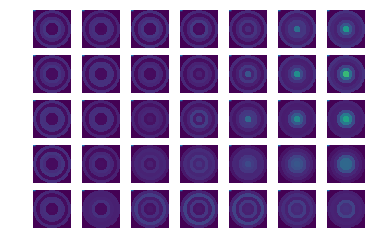

In [66]:
for key in (keylist[1],):
    plt.figure()
    for i in range(trialavg[key].shape[1]):
        for j in range(trialavg[key].shape[2]):
            plt.subplot(trialavg[key].shape[1],trialavg[key].shape[2],i*trialavg[key].shape[2]+j+1)
            plt.plot(trialavg[key][:,i,j])
            plt.imshow(make_bullseye(trialavg[key].shape[0],trialavg[key][:,i,j]),vmin=0,vmax=1)
            plt.axis('off')
    plt.savefig('size_contrast_by_rf_non_norm.pdf')
    plt.savefig('size_contrast_by_rf_non_norm.png')